<a href="https://colab.research.google.com/github/Pranshu-Bahadur/G-AI4Code/blob/main/Protein_Sequence_Family_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Structural Protein Sequences](https://www.kaggle.com/datasets/shahir/protein-data-set)
---

In this work we perform a study on using Natural Language Processing (NLP) from protein sequence family classification.

Our dataset contains > 400,000 protein structure sequences.

# 0. Prelim Set-up

In this section we will set-up additional dependencies utilized in our study

Just run the following to get started:

First lets mount GDrive (make sure the dataset files are stored in your GDrive).

In [694]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Understanding our Dataset

In this section we will analyze our dataset the following way:



1.   Load the dataset into a DataFrame
2.   Clean our raw dataset
3.   Identify the target variable
4.   Analyze the features in our dataset
5.   Plot Distributions and perform features engineering


## 1.0 Dataset curation


In this section we clean and refine our dataset.

### 1.0.1 Prelim Exploration of the Datasets



Our dataset consists of two .csv files:

* **pdb_data_no_dups.csv** contains protein meta data which includes details on protein classification, extraction methods, etc.


* **data_seq.csv** contains >400,000 protein structure sequences.

In [695]:
# filepaths for the csvs
csv_fpaths = {
    "pdb_data_no_dups" : '/content/drive/MyDrive/sps_dataset/pdb_data_no_dups.csv',
    "data_seq" : '/content/drive/MyDrive/sps_dataset/pdb_data_seq.csv'
}

Let's first load each .csvs into pandas DataFrame so we can gain functionality to understand the nature of the dataset.

In [696]:
from pandas import read_csv

dataframes = {k: read_csv(v) for k, v in csv_fpaths.items()}

Let's see the data provided in the first dataframe:

 **pdb_data_no_dups**

In [697]:
dataframes['pdb_data_no_dups'].head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear
0,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0
1,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0
2,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0
3,102D,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,2.28,46.06,"pH 7.00, VAPOR DIFFUSION, SITTING DROP, temper...",7.0,1995.0
4,102L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,1993.0


In [698]:
print(dataframes['pdb_data_no_dups'].columns)

Index(['structureId', 'classification', 'experimentalTechnique',
       'macromoleculeType', 'residueCount', 'resolution',
       'structureMolecularWeight', 'crystallizationMethod',
       'crystallizationTempK', 'densityMatthews', 'densityPercentSol',
       'pdbxDetails', 'phValue', 'publicationYear'],
      dtype='object')


Lets do the same for the second dataframe

In [699]:
dataframes['data_seq'].head(10)

,structureId,chainId,sequence,residueCount,macromoleculeType
0,100D,A,CCGGCGCCGG,20,DNA/RNA Hybrid
1,100D,B,CCGGCGCCGG,20,DNA/RNA Hybrid
2,101D,A,CGCGAATTCGCG,24,DNA
3,101D,B,CGCGAATTCGCG,24,DNA
4,101M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein
5,102D,A,CGCAAATTTGCG,24,DNA
6,102D,B,CGCAAATTTGCG,24,DNA
7,102L,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,165,Protein
8,102M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein
9,103D,A,GTGGAATGGAAC,24,DNA


In [700]:
print(dataframes['data_seq'].columns)

Index(['structureId', 'chainId', 'sequence', 'residueCount',
       'macromoleculeType'],
      dtype='object')


This prelim look at both dataframes raises the following questions:

* What is **structureId** & **chainId**?

> * **structureId**: Uniquely identifies a protein structure (4 digits)

> *	**chainId**: Uniquely identifies a polypeptide chain within a protein structure (1-2 digits)


💡 _**insight**_ This could mean that for each structureId could have multiple chainIds in the second dataframe.

Let's check if the number of rows in both DataFrames are equal.

In [701]:
dataframes['data_seq'].size == dataframes['pdb_data_no_dups'].size

False

Let's confirm if structureId are unique values in the both dataframes.

In [702]:
dataframes['pdb_data_no_dups'].size

1979614

In [703]:
dataframes['pdb_data_no_dups']['structureId'].size

141401

In [704]:
dataframes['data_seq'].size

2336520

In [705]:
dataframes['data_seq']['structureId'].size

467304

💡 As we can see this is not the case.

Therefore dropping duplicate sequences (as done [here](https://www.kaggle.com/code/danofer/deep-protein-sequence-family-classification)) would cause the loss of chainIds.

Let's identify the columns that are in common between both dataframes.

In [706]:
dataframes['pdb_data_no_dups'].columns.intersection(dataframes['data_seq'].columns)

Index(['structureId', 'macromoleculeType', 'residueCount'], dtype='object')

### 1.0.2 Dataset Cleaning


Before we create a new Id string we need to make sure to Impute / remove data that is NA in each column and since we are only dealing with protein sequences in this study lets only extract protein sequences (given in macromoleculeType).

Filtering out macromoleculeType

In [707]:
cleaned_dataframes = {k: v[v['macromoleculeType'] == 'Protein'].dropna() for k, v in dataframes.items()}

Droping rows with missing values:

In [708]:
cleaned_dataframes = {k: v.where(v != '', v) for k, v in dataframes.items()}

In [709]:
cleaned_dataframes['pdb_data_no_dups'].size

1979614

In [710]:
cleaned_dataframes['data_seq'].size

2336520

Let's merge our dataset by structureId

❓ Why are more than just protein macromoleculeType given in a protein sequence dataset?

In [711]:
from functools import reduce
from pandas import merge

final_dataset = reduce(lambda df1, df2: merge(df1, df2, how='inner', on='structureId'), cleaned_dataframes.values())

In [712]:
final_dataset.size

8480682

In [713]:
final_dataset = final_dataset[['classification', 'sequence']].drop_duplicates('sequence')

In [714]:
final_dataset.size

209626

In [715]:
final_dataset = final_dataset.reset_index(drop=True)

In [716]:
final_dataset

,classification,sequence
0,DNA-RNA HYBRID,CCGGCGCCGG
1,DNA,CGCGAATTCGCG
2,OXYGEN TRANSPORT,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
3,DNA,CGCAAATTTGCG
4,HYDROLASE(O-GLYCOSYL),MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
...,...,...
104808,ANTIFREEZE PROTEIN,ANQASVVANQLIPINTALNLVMMRSEVVTPVGIPAEDIPRLVSMQV...
104809,HYDROLASE INHIBITOR,VHHPPSYVAHLASDFGVRVFQQVAQASKDRNVVFSPYGVASVLAML...
104810,HYDROLASE INHIBITOR,MAPEEIIMDRPFLFVVRHNPTGTVLFMGQVMEP
104811,ELECTRON TRANSPORT,LEVLLGSGDGSLVFVPSEFSVPSGEKIVFKNNAGFPHNVVFDEDEI...


Finally lets save our dataset for further exploration in the next section

In [717]:
final_dataset.classification.size

104813

In [718]:
final_dataset.sequence.size

104813

In [719]:
final_dataset.size

209626

In [720]:
final_dataset.to_csv("/content/drive/MyDrive/sps_dataset/pdb.csv")

## 1.1 Exploratory Data Analysis

In this section we will do the following:



1. Load our dataset
2. Understand classification labels
3. Understand sequences

### 1.1.1 Load our dataset

In [721]:
from pandas import read_csv

df = read_csv('/content/drive/MyDrive/sps_dataset/pdb.csv')

In [722]:
df.size

314439

In [723]:
df = df.drop('Unnamed: 0', axis=1).reset_index()

In [724]:
df

,index,classification,sequence
0,0,DNA-RNA HYBRID,CCGGCGCCGG
1,1,DNA,CGCGAATTCGCG
2,2,OXYGEN TRANSPORT,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
3,3,DNA,CGCAAATTTGCG
4,4,HYDROLASE(O-GLYCOSYL),MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
...,...,...,...
104808,104808,ANTIFREEZE PROTEIN,ANQASVVANQLIPINTALNLVMMRSEVVTPVGIPAEDIPRLVSMQV...
104809,104809,HYDROLASE INHIBITOR,VHHPPSYVAHLASDFGVRVFQQVAQASKDRNVVFSPYGVASVLAML...
104810,104810,HYDROLASE INHIBITOR,MAPEEIIMDRPFLFVVRHNPTGTVLFMGQVMEP
104811,104811,ELECTRON TRANSPORT,LEVLLGSGDGSLVFVPSEFSVPSGEKIVFKNNAGFPHNVVFDEDEI...


### 1.1.2 Lets understand the distribution of the classification labels.

<ipython-input-725-7e900918f305>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(counts, hist = False, color = 'purple')


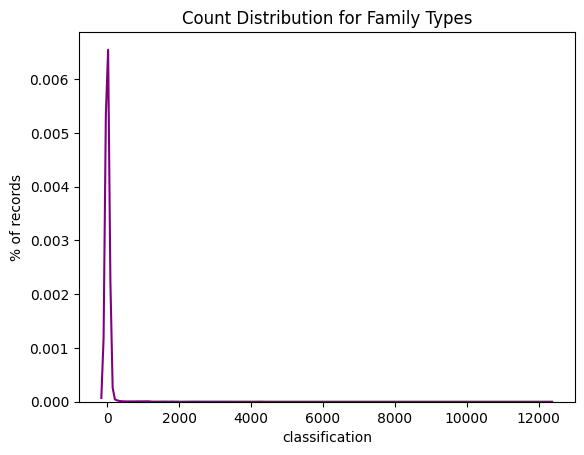

In [725]:
from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sns

counts = df.classification.value_counts()

plt.figure()
sns.distplot(counts, hist = False, color = 'purple')
plt.title('Count Distribution for Family Types')
plt.ylabel('% of records')
plt.show()

In [726]:
DataFrame(counts)

,classification
HYDROLASE,12214
TRANSFERASE,8980
OXIDOREDUCTASE,7034
IMMUNE SYSTEM,5215
RIBOSOME,4226
...,...
LIGASE(AMIDE SYNTHETASE),1
"RECOMBINATION, DNA",1
"CELL ADHESION, SUGAR BINDING PROTEIN",1
"Chaperone, hydrolase",1


💡 This looks heavily skewed which tells us < 1000 classes have enough data to be relevant to solving this problem.

### 1.1.3 Lets analyze the sequence lengths.

count    104812.000000
mean        237.933195
std         234.641357
min           1.000000
25%         100.000000
50%         198.000000
75%         320.000000
max        5070.000000
Name: sequence, dtype: float64


<ipython-input-727-ab7005bbb49a>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(seq_lengths, hist = False, color = 'purple')


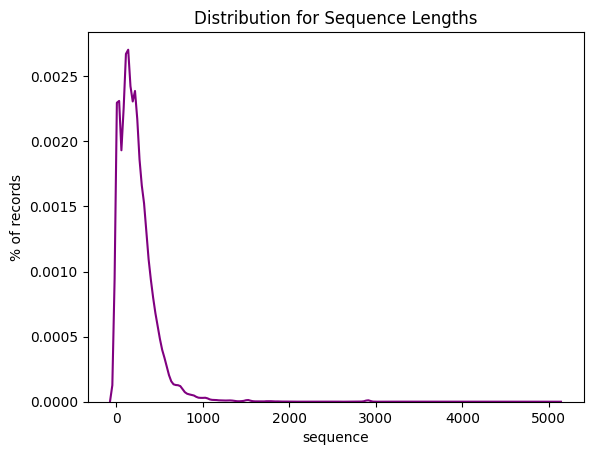

In [727]:
from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sns

seq_lengths = df.sequence.str.len()

print(seq_lengths.describe())


plt.figure()
sns.distplot(seq_lengths, hist = False, color = 'purple')
plt.title('Distribution for Sequence Lengths')
plt.ylabel('% of records')
plt.show()

💡 Most sequences are < 1000

### 1.1.4 Pruning the dataset

From the previous subsections we inferred the following:



1.   This dataset is heavily imbalanced in terms of classes (<1000 are relevant)
2.   This dataset is heavily imbalanced in terms of sequence lengths (lengths of <1000 are viable)




Since ~0% of both cases are greater than 1000 discarding these values should not affect our study.


In [728]:
classes = df.classification.value_counts().head(1000).index

df = df[df.apply(lambda x: x.classification in classes, axis=1)]

In [729]:
df.sequence.size

99025